In [2]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

import pcms.tree

### Define helper functions

In [3]:
def find_minor_split_sizes(t):
    subtree_sizes = []
    minor_split_sizes   = []
    for i in range(t.n_nodes):
        children = t.find_children(i)
        if len(children) != 2:
            continue
        n = t.get_subtree_size(i)
        c1, c2 = children
        m = min(t.get_subtree_size(c1), t.get_subtree_size(c2))
        subtree_sizes.append(n)
        minor_split_sizes.append(m)
    return subtree_sizes, minor_split_sizes

In [4]:
def plot_minor_split_sizes(subtree_sizes, minor_split_sizes, sample_median=False):
    fig, ax = plt.subplots(figsize=(9,7))

    xvals = np.linspace(min(subtree_sizes), max(subtree_sizes), 500)

    ax.scatter(
        subtree_sizes, minor_split_sizes, 
        label="Minor split sizes", 
        color="black", s=0.2, alpha=0.7
    )

    if sample_median:
        # Rolling sample median
        window_size = 500
        df = pd.DataFrame({"subtree_sizes": subtree_sizes, "minor_split_sizes": minor_split_sizes})
        df = df.sort_values("subtree_sizes")
        df["rolling_median"] = df["minor_split_sizes"].rolling(window=window_size, center=True, min_periods=1).median()

        # Plot rolling median
        ax.plot(
            df["subtree_sizes"], df["rolling_median"], 
            label="Rolling median", 
            color="blue", linewidth=2, alpha=0.8
        )

    # O(n^1/2) reference line
    ax.plot(
        xvals, xvals**0.5, 
        label=r"$\mathrm{O}(n^{1/2})$", 
        color="red", linewidth=2
    )

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("Subtree size", fontsize=14)
    ax.set_ylabel("Minor split size", fontsize=14)

    ax.legend(fontsize=14, frameon=True, framealpha=0.9, loc="upper left")

    return fig, ax

In [5]:
def find_n_children(t):
    n_children = np.ndarray(shape=(t.n_nodes,), dtype=np.int32)
    for i in range(t.n_nodes):
        n = len(t.find_children(i))
        n_children[i] = n
    return n_children

In [6]:
def plot_n_children_distribution(n_children, log=False, bins=50):
    fig, ax = plt.subplots(figsize=(9, 7))

    ax.hist(n_children, bins=bins, edgecolor="black", log=log, alpha=0.8)

    ax.set_xlabel("Number of Children")
    ax.set_ylabel("Count")

    return fig, ax

### Load Greengenes datasets

In [7]:
data_dir = os.path.join(os.environ.get("DATA"), "greengenes/")
gg_dirs  = ['gg_11_2_otus', 'gg_12_10_otus', 'gg_13_5_otus', 'gg_13_8_otus']
nwk_filepaths = [
    os.path.join(data_dir, gg_dir, "trees", filename)
    for gg_dir in gg_dirs
    for filename in os.listdir(os.path.join(data_dir, gg_dir, "trees"))
    if filename.endswith(".nwk")
]
nwk_filepaths_binary = nwk_filepaths.copy()

In [8]:
print(nwk_filepaths_binary)

['/home/sean/Data/greengenes/gg_11_2_otus/trees/97_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/76_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/79_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/94_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/73_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/82_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/91_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/85_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/88_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/70_otus.nwk', '/home/sean/Data/greengenes/gg_11_2_otus/trees/99_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/97_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/76_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/79_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/64_otus.nwk', '/home/sean/Data/greengenes/gg_12_10_otus/trees/94_otus.nwk', '/home/sean/Data/g

In [9]:
for filepath in nwk_filepaths:
    t = pcms.tree.nwk2tree(filepath)
    n_children = np.ndarray(shape=(t.n_nodes,), dtype=np.int32)
    for i in range(t.n_nodes):
        n = len(t.find_children(i))
        n_children[i] = n
    if n_children[(n_children != 0) & (n_children != 1) & (n_children != 2)].size != 0:
        print(f"polytomies found in {filepath}.")
        nwk_filepaths_binary.remove(filepath)

polytomies found in /home/sean/Data/greengenes/gg_11_2_otus/trees/99_otus.nwk.
polytomies found in /home/sean/Data/greengenes/gg_13_5_otus/trees/99_otus.nwk.
polytomies found in /home/sean/Data/greengenes/gg_13_8_otus/trees/99_otus_unannotated.nwk.
polytomies found in /home/sean/Data/greengenes/gg_13_8_otus/trees/99_otus.nwk.


### `nwk2tree`

In [10]:
start = time.time()
t = pcms.tree.nwk2tree(os.path.join(data_dir, "gg_13_8_otus/trees/99_otus.nwk"))
print(f"Time to parse: {time.time() - start:0.3}")
print(f"Tree size: {t.n_nodes:,}")
print(f"Covariance matrix size: {t.n_nodes**2:,}")
print(f"Minimum sparsification: {1 - (2 * (t.find_epl() + 1) / (t.n_nodes**2) - 3 / t.n_nodes)}")

Time to parse: 0.0651
Tree size: 406,886
Covariance matrix size: 165,556,216,996
Minimum sparsification: 0.9998656029087658


In [11]:
print("is_planted: ", t.find_is_planted())
print("root degree: ", t.find_children(t.find_root()).size)

is_planted:  False
root degree:  2


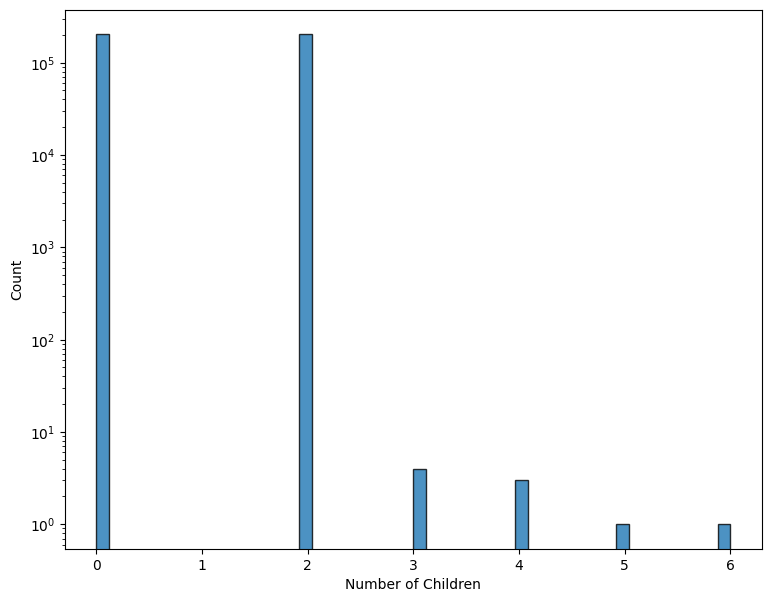

In [12]:
fig, ax = plot_n_children_distribution(find_n_children(t), log=True)
plt.show()

In [13]:
data_dir2 = os.path.join(os.environ.get("DATA"), "greengenes2/")

In [14]:
start = time.time()
t = pcms.tree.nwk2tree(os.path.join(data_dir2, "gg_22_10_otus/2022.10.phylogeny.id.nwk"))
print(f"Time to parse: {time.time() - start:0.3}")
print(f"Tree size: {t.n_nodes:,}")
print(f"Covariance matrix size: {t.n_nodes**2:,}")
print(f"Minimum sparsification: {1 - (2 * (t.find_epl() + 1) / (t.n_nodes**2) - 3 / t.n_nodes)}")

Time to parse: 3.66
Tree size: 22,090,656
Covariance matrix size: 487,997,082,510,336
Minimum sparsification: 0.9999934424195335


In [15]:
print("is_planted: ", t.find_is_planted())
print("root degree: ", t.find_children(t.find_root()).size)

is_planted:  False
root degree:  2


In [16]:
n_children = find_n_children(t)

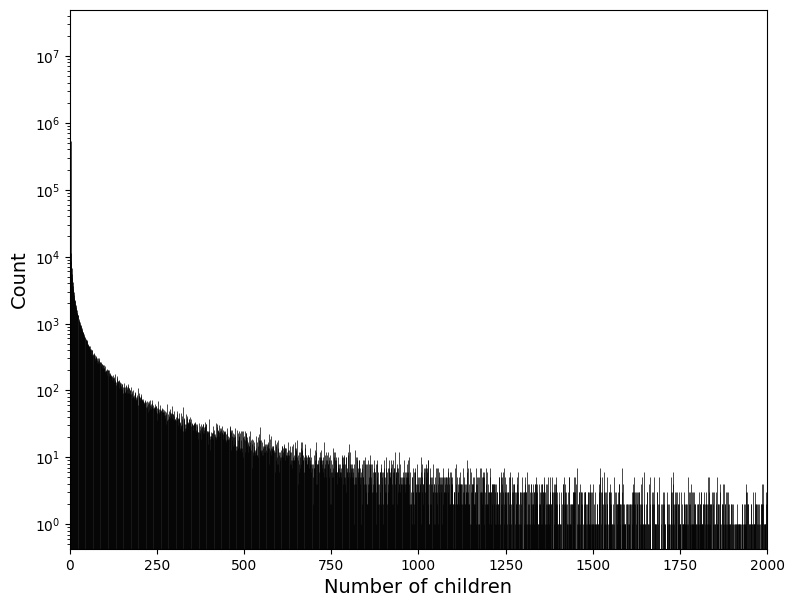

In [17]:
fig, ax = plt.subplots(figsize=(9,7))

counts, bin_edges = np.histogram(n_children, bins=np.max(n_children))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot each bin as an individual vertical line
for bin_center, count in zip(bin_centers, counts):
    ax.vlines(bin_center, ymin=0, ymax=count, colors='black', linewidth=0.5)

# Rescale axes
# ax.set_xscale('symlog', linthresh=1e3)
ax.set_xlim([0,2e3])
ax.set_yscale('log')

# Labels and formatting
ax.set_xlabel("Number of children", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

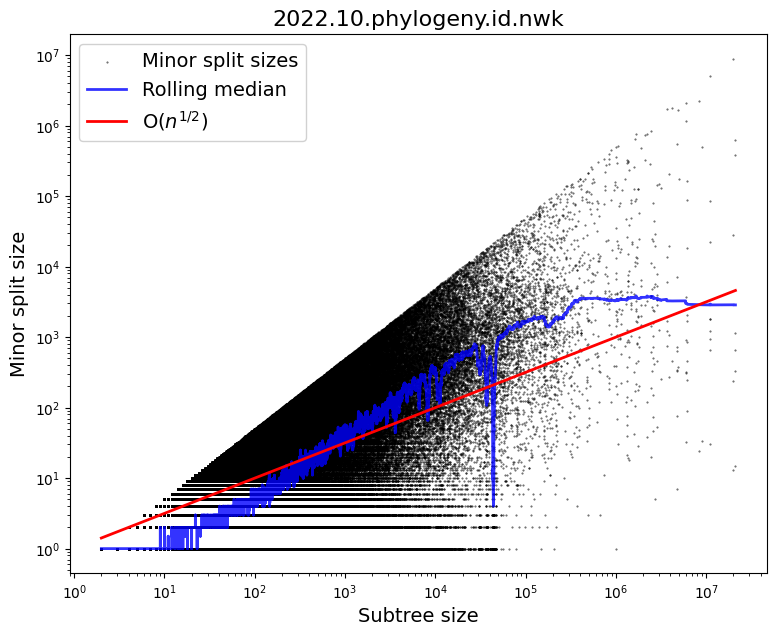

In [18]:
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("2022.10.phylogeny.id.nwk", fontsize=16)
plt.show()

### Minor split size of a Greengenes tree

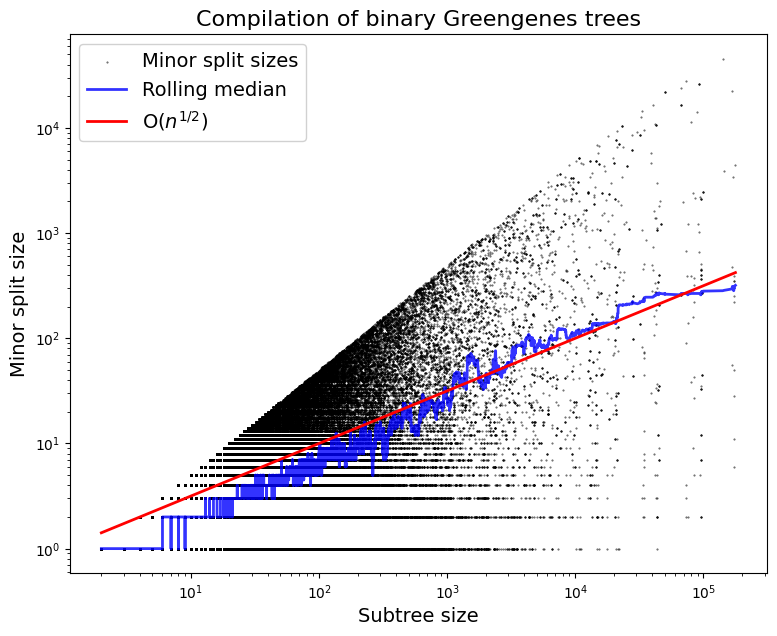

In [19]:
subtree_sizes = []
minor_split_sizes = []
for filepath in nwk_filepaths_binary:
    t = pcms.tree.nwk2tree(filepath)
    a, b = find_minor_split_sizes(t)
    subtree_sizes += a
    minor_split_sizes += b
fig, ax = plot_minor_split_sizes(subtree_sizes, minor_split_sizes, sample_median=True)
ax.set_title("Compilation of binary Greengenes trees", fontsize=16)
plt.show()

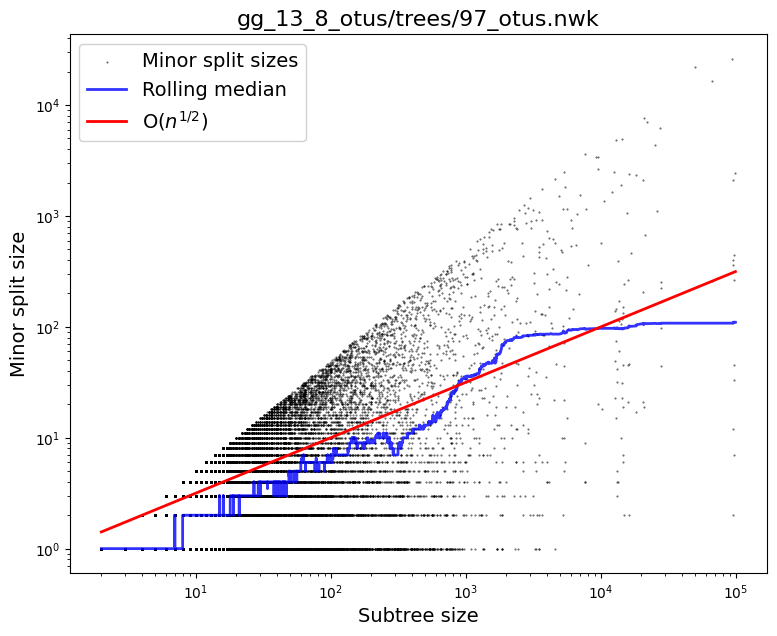

In [19]:
t = pcms.tree.nwk2tree(os.path.join(data_dir, "gg_13_8_otus/trees/97_otus.nwk"))
n_leaves = t.n_nodes//2
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("gg_13_8_otus/trees/97_otus.nwk", fontsize=16)
plt.show()

### Minor split size of a critical beta-splitting tree

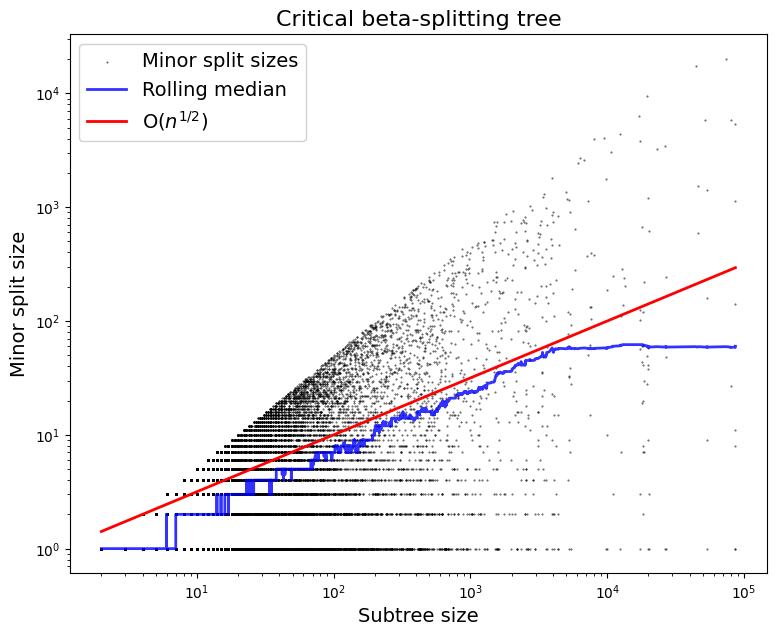

In [21]:
t = pcms.tree.cbst(n_leaves=n_leaves)
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("Critical beta-splitting tree", fontsize=16)
plt.show()

### Minor split size of a uniform tree

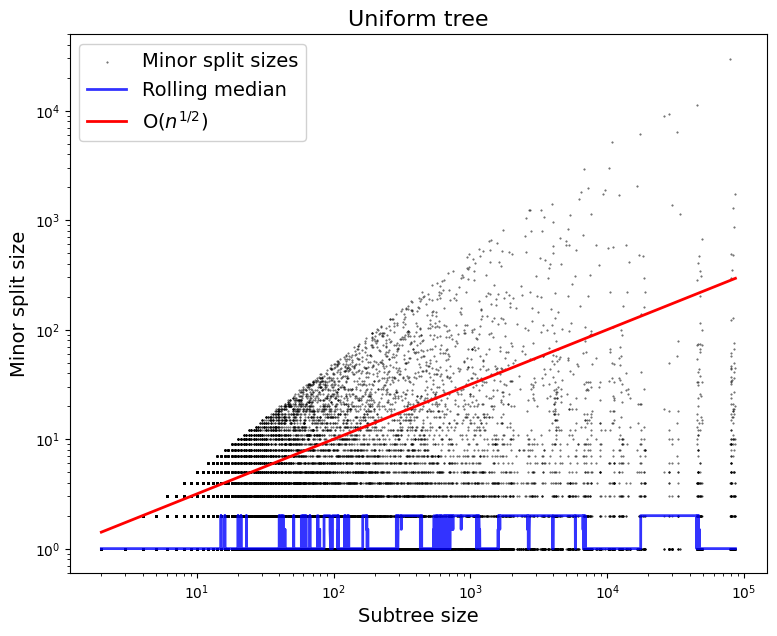

In [22]:
t = pcms.tree.remy(n_leaves=n_leaves)
fig, ax = plot_minor_split_sizes(*find_minor_split_sizes(t), sample_median=True)
ax.set_title("Uniform tree", fontsize=16)
plt.show()

### Comparison of $EPL(T_n)/n^2$

In [50]:
def find_ratios(t):
    ns = []
    rs = []
    for i in t.find_interior_nodes():
        n = t.get_subtree_size(i)
        ns.append(n)
        _, depths = t.find_leaves(i)
        rs.append(depths.sum() / n**2)
    return ns, rs

In [37]:
subtree_sizes_gg = []
ratios_gg = []
for filepath in nwk_filepaths_binary:
    t = pcms.tree.nwk2tree(filepath)
    ns, rs = find_ratios(t)
    subtree_sizes_gg += ns
    ratios_gg += rs

In [33]:
N = 30
ts = pcms.tree.cbst(n_leaves=100000, n_samples=N)

In [34]:
subtree_sizes_cbst = []
ratios_cbst = []
for t in ts:
    ns, rs = find_ratios(t)
    subtree_sizes_cbst += ns
    ratios_cbst += rs

In [39]:
N = 30
ts_unif = pcms.tree.remy(n_leaves=100000, n_samples=N)

In [42]:
subtree_sizes_unif = []
ratios_unif = []
for t in ts_unif:
    ns, rs = find_ratios(t)
    subtree_sizes_unif += ns
    ratios_unif += rs

In [52]:
subtree_sizes_gg = np.asarray(subtree_sizes_gg)
subtree_sizes_cbst = np.asarray(subtree_sizes_cbst)
subtree_sizes_unif = np.asarray(subtree_sizes_unif)
ratios_gg = np.asarray(ratios_gg)
ratios_cbst = np.asarray(ratios_cbst)
ratios_unif = np.asarray(ratios_unif)

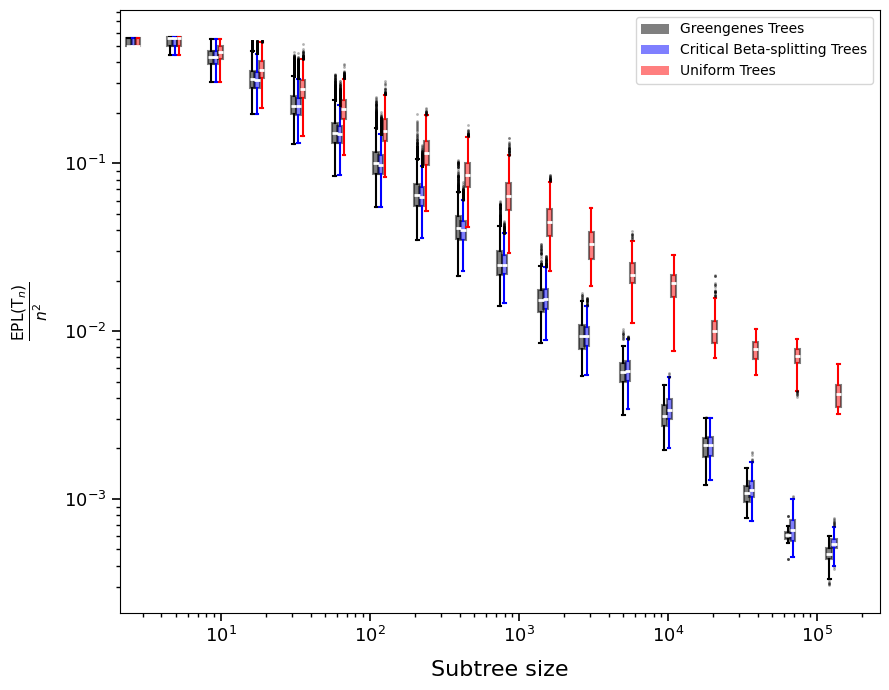

In [57]:
# Define log-spaced bins for subtree sizes
n_bins = 20  # tweak for resolution
bins = np.logspace(
    np.log10(min(subtree_sizes_gg.min(), subtree_sizes_cbst.min(), subtree_sizes_unif.min())),
    np.log10(max(subtree_sizes_gg.max(), subtree_sizes_cbst.max(), subtree_sizes_unif.max())),
    n_bins
)

# Digitize each dataset into bins
inds_gg   = np.digitize(subtree_sizes_gg,   bins)
inds_cbst = np.digitize(subtree_sizes_cbst, bins)
inds_unif = np.digitize(subtree_sizes_unif, bins)

# Collect binned values
data_gg   = [ratios_gg[inds_gg == i]       for i in range(1, len(bins))]
data_cbst = [ratios_cbst[inds_cbst == i]   for i in range(1, len(bins))]
data_unif = [ratios_unif[inds_unif == i]   for i in range(1, len(bins))]

# Compute x-positions at bin centers
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # geometric mean

fig, ax = plt.subplots(figsize=(9, 7))

# Offsets so boxplots don’t overlap
offset = 0.07
# Use proportional widths but enforce a minimum so they stay visible
widths = np.maximum(bin_centers * 0.08, 0.2)

# Common style dictionaries
box_style = dict(linewidth=1.5)
median_style = dict(color="white", linewidth=2)
flier_style = dict(marker=".", markersize=2, alpha=0.3)

# Plot GG boxplots
bp1 = ax.boxplot(
    data_gg, positions=bin_centers * (1 - offset), widths=widths,
    patch_artist=True,
    boxprops=dict(facecolor="black", alpha=0.5, **box_style),
    medianprops=median_style,
    whiskerprops=dict(color="black", **box_style),
    capprops=dict(color="black", **box_style),
    flierprops=flier_style
)

# Plot CBST boxplots
bp2 = ax.boxplot(
    data_cbst, positions=bin_centers, widths=widths,
    patch_artist=True,
    boxprops=dict(facecolor="blue", alpha=0.5, **box_style),
    medianprops=median_style,
    whiskerprops=dict(color="blue", **box_style),
    capprops=dict(color="blue", **box_style),
    flierprops=flier_style
)

# Plot UNIF boxplots
bp3 = ax.boxplot(
    data_unif, positions=bin_centers * (1 + offset), widths=widths,
    patch_artist=True,
    boxprops=dict(facecolor="red", alpha=0.5, **box_style),
    medianprops=median_style,
    whiskerprops=dict(color="red", **box_style),
    capprops=dict(color="red", **box_style),
    flierprops=flier_style
)

ax.set_xscale("log")
ax.set_yscale("log")

# Labels
ax.set_xlabel("Subtree size", fontsize=16, labelpad=10)
ax.set_ylabel(r"$\frac{\mathrm{EPL}(\mathrm{T}_n)}{n^2}$", fontsize=16, labelpad=10)

# Legend
ax.legend(
    [
        Patch(facecolor="black", alpha=0.5),
        Patch(facecolor="blue", alpha=0.5),
        Patch(facecolor="red", alpha=0.5)
    ],
    ["Greengenes Trees", "Critical Beta-splitting Trees", "Uniform Trees"],
    loc="best"
)

# Ticks
ax.tick_params(axis="both", which="major", labelsize=13, length=6, width=1.2)
ax.tick_params(axis="both", which="minor", labelsize=11, length=3, width=1.0)

plt.tight_layout()
plt.show()